# Notebook 5 – Red Neuronal MLP Básica ( clasificación )

**Objetivo de la sesión (≈55–60 min)**  
- Entender cómo funciona una red neuronal simple (MLP) en un problema de clasificación.  
- Ver el entrenamiento por *epochs* a través de la curva de pérdida.  
- Modificar **un solo hiperparámetro** y observar su impacto en rendimiento.  
- Conectar con lo visto en modelos supervisados tradicionales (Logistic / Tree / RF).

Trabajaremos primero con un **dataset sintético 2D** (fácil de visualizar) y luego haremos un **segundo experimento** cambiando la arquitectura.


In [19]:
# 📦 1. Importar librerías

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## 2. Crear dataset sintético (make_moons)

Usaremos `make_moons`, un dataset clásico de clasificación binaria donde las clases no son linealmente separables.  
Esto nos permite ver claramente **cuándo una red neuronal aporta más que una regresión logística**.


Dimensión de X: (1000, 2)
Dimensión de y: (1000,)


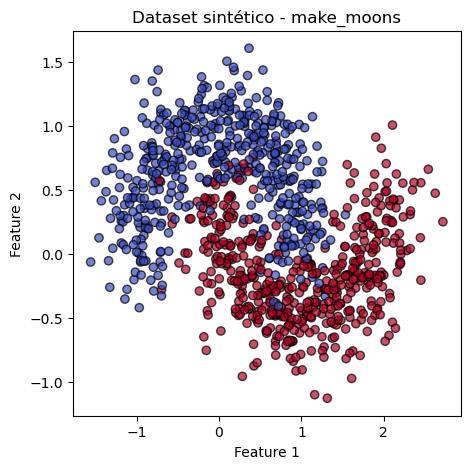

In [20]:
# 2. Crear dataset sintético
X, y = make_moons(n_samples=1000, noise=0.25, random_state=42)

print("Dimensión de X:", X.shape)
print("Dimensión de y:", y.shape)

# Visualización rápida del dataset
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolor="k", alpha=0.7)
plt.title("Dataset sintético - make_moons")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


## 3. Separar train/test y escalar variables

Las redes neuronales son muy sensibles a la **escala de las variables**, por eso aplicamos `StandardScaler`.


In [21]:
# 3. Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Escalamiento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Tamaño train:", X_train_scaled.shape)
print("Tamaño test:", X_test_scaled.shape)


Tamaño train: (750, 2)
Tamaño test: (250, 2)


## 4. Modelo base: MLP simple

Partimos con una arquitectura muy sencilla:

- Una sola capa oculta con 8 neuronas (`hidden_layer_sizes=(8,)`)
- Activación ReLU  
- Máximo 300 iteraciones (epochs internos de `MLPClassifier`)

Luego veremos la **curva de pérdida** (`loss_curve_`) para entender cómo aprende.


In [22]:
# 4. Definir y entrenar modelo base
mlp_base = MLPClassifier(
    hidden_layer_sizes=(8,),
    activation="relu",
    solver="adam",
    learning_rate_init=0.01,
    max_iter=300,
    random_state=42
)

mlp_base.fit(X_train_scaled, y_train)

print("Número de epochs realmente usados:", len(mlp_base.loss_curve_))


Número de epochs realmente usados: 269


## 5. Curva de pérdida (loss) por epoch

La curva de pérdida nos muestra cómo el modelo va **minimizando el error** en el conjunto de entrenamiento.


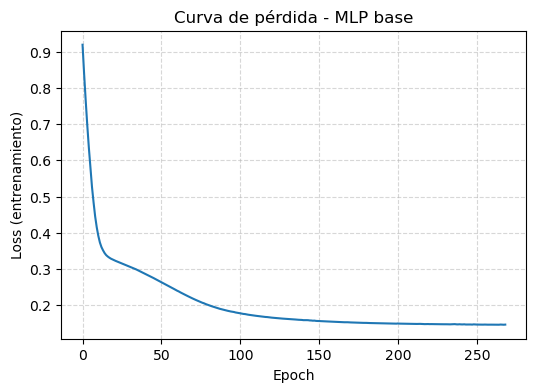

In [23]:
# 5. Plot de la curva de pérdida
plt.figure(figsize=(6, 4))
plt.plot(mlp_base.loss_curve_)
plt.xlabel("Epoch")
plt.ylabel("Loss (entrenamiento)")
plt.title("Curva de pérdida - MLP base")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


## 6. Evaluación del modelo base

Mediremos:

- **Accuracy** en train y test  
- **Clasification report** (precision, recall, f1)  
- **Matriz de confusión**


In [25]:
# 6. Evaluación
y_train_pred = mlp_base.predict(X_train_scaled)
y_test_pred = mlp_base.predict(X_test_scaled)

print("Accuracy TRAIN:", round(accuracy_score(y_train, y_train_pred), 3))
print("Accuracy TEST :", round(accuracy_score(y_test, y_test_pred), 3))

print("\nClassification report (TEST):")
print(classification_report(y_test, y_test_pred))

print("Matriz de confusión (TEST):")
print(confusion_matrix(y_test, y_test_pred))


Accuracy TRAIN: 0.944
Accuracy TEST : 0.964

Classification report (TEST):
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       125
           1       0.95      0.98      0.96       125

    accuracy                           0.96       250
   macro avg       0.96      0.96      0.96       250
weighted avg       0.96      0.96      0.96       250

Matriz de confusión (TEST):
[[118   7]
 [  2 123]]


## 7. Visualizar frontera de decisión del MLP

En dos dimensiones podemos **ver literalmente** cómo la red separa las clases.


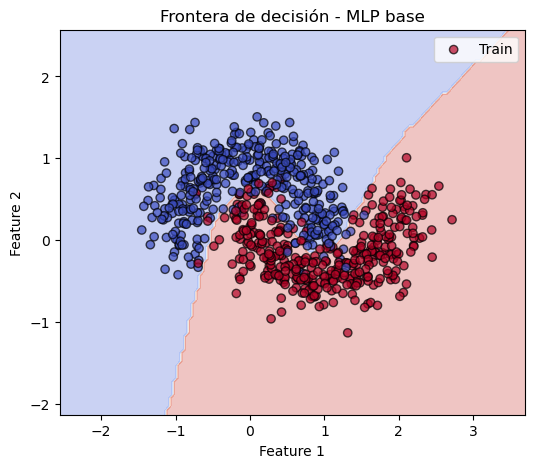

In [26]:
# 7. Frontera de decisión del MLP base
h = 0.05  # tamaño de paso para la malla
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

grid = np.c_[xx.ravel(), yy.ravel()]
grid_scaled = scaler.transform(grid)
Z = mlp_base.predict(grid_scaled)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(6, 5))
plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="coolwarm",
            edgecolor="k", alpha=0.7, label="Train")
plt.title("Frontera de decisión - MLP base")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


---

## 8. Segundo experimento: cambiar un hiperparámetro

Ahora modificaremos **solo un hiperparámetro** para ver el impacto:

> Ejemplo: aumentar la capacidad del modelo  
> de `(8,)` neuronas a `(16, 16)` neuronas.

La idea es comparar:

- Curva de pérdida  
- Accuracy en test  
- Forma de la frontera de decisión


In [27]:
# 8. MLP más profundo / más neuronas
mlp_deep = MLPClassifier(
    hidden_layer_sizes=(16, 16),
    activation="relu",
    solver="adam",
    learning_rate_init=0.01,
    max_iter=400,
    random_state=42
)

mlp_deep.fit(X_train_scaled, y_train)

print("Epochs usados (modelo deep):", len(mlp_deep.loss_curve_))


Epochs usados (modelo deep): 105


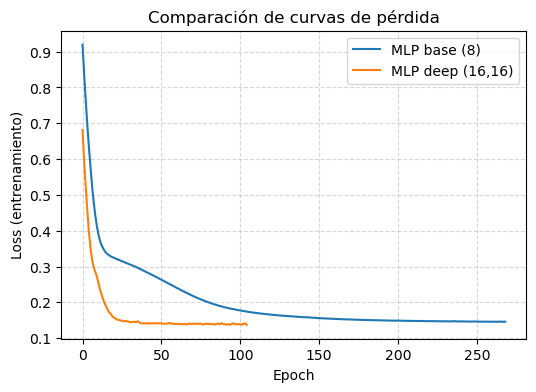

In [28]:
# Comparar curvas de pérdida base vs deep
plt.figure(figsize=(6, 4))
plt.plot(mlp_base.loss_curve_, label="MLP base (8)")
plt.plot(mlp_deep.loss_curve_, label="MLP deep (16,16)")
plt.xlabel("Epoch")
plt.ylabel("Loss (entrenamiento)")
plt.title("Comparación de curvas de pérdida")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [30]:
# Evaluar nuevo modelo
y_test_pred_deep = mlp_deep.predict(X_test_scaled)

print("Accuracy TEST MLP base :", accuracy_score(y_test, y_test_pred),3)
print("Accuracy TEST MLP deep :", accuracy_score(y_test, y_test_pred_deep),3)

print("\nMatriz de confusión (TEST) - MLP deep:")
print(confusion_matrix(y_test, y_test_pred_deep))


Accuracy TEST MLP base : 0.964 3
Accuracy TEST MLP deep : 0.98 3

Matriz de confusión (TEST) - MLP deep:
[[123   2]
 [  3 122]]


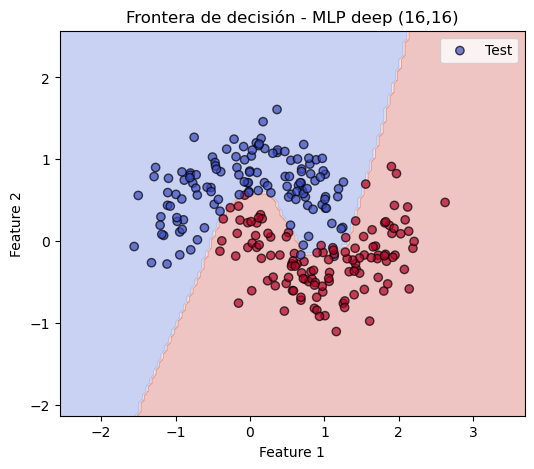

In [31]:
# Frontera de decisión del modelo deep
Z_deep = mlp_deep.predict(grid_scaled)
Z_deep = Z_deep.reshape(xx.shape)

plt.figure(figsize=(6, 5))
plt.contourf(xx, yy, Z_deep, alpha=0.3, cmap="coolwarm")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="coolwarm",
            edgecolor="k", alpha=0.7, label="Test")
plt.title("Frontera de decisión - MLP deep (16,16)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


---

## 9. Mini-desafío (para los participantes)

👉 **Tarea:** cambiar **solo un hiperparámetro** del MLP y justificar el resultado:

- Opción 1: `learning_rate_init` (p.ej. 0.001 o 0.1)  
- Opción 2: `alpha` (regularización L2)  
- Opción 3: `hidden_layer_sizes` (más o menos neuronas/capas)

Pasos:

1. Copiar el bloque de entrenamiento de `mlp_base`.  
2. Cambiar un hiperparámetro.  
3. Volver a entrenar.  
4. Comparar:
   - Curva de pérdida  
   - Accuracy en test  
   - Forma de la frontera de decisión


c:\Users\felip\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


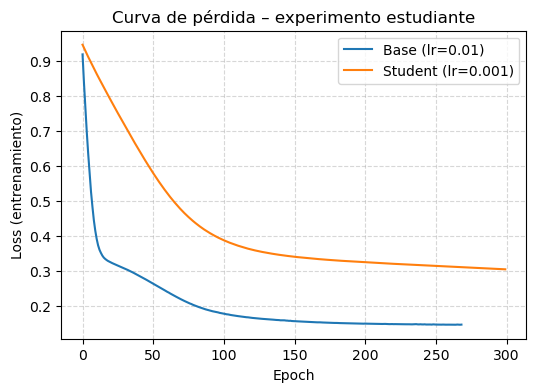

Accuracy TEST base   : 0.964 3
Accuracy TEST alumno : 0.924 3


In [33]:
# 9. Espacio para experimento del estudiante

# === EJEMPLO: modificar learning_rate_init ===
mlp_student = MLPClassifier(
    hidden_layer_sizes=(8,),
    activation="relu",
    solver="adam",
    learning_rate_init=0.001,  # <-- MODIFIQUEN SOLO ESTO (o 1 parámetro)
    max_iter=300,
    random_state=42
)

mlp_student.fit(X_train_scaled, y_train)

# Curva de pérdida
plt.figure(figsize=(6, 4))
plt.plot(mlp_base.loss_curve_, label="Base (lr=0.01)")
plt.plot(mlp_student.loss_curve_, label="Student (lr=0.001)")
plt.xlabel("Epoch")
plt.ylabel("Loss (entrenamiento)")
plt.title("Curva de pérdida – experimento estudiante")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Accuracy test
y_test_pred_student = mlp_student.predict(X_test_scaled)
print("Accuracy TEST base   :", accuracy_score(y_test, y_test_pred),3)
print("Accuracy TEST alumno :", accuracy_score(y_test, y_test_pred_student),3)


---

## 10. Conclusión rápida (para discusión en clase)

Algunas preguntas para cerrar la sesión:

1. ¿En qué se diferencia este MLP de los modelos supervisados que ya vimos (Logistic, Tree, Random Forest)?  
2. ¿Qué ventajas observan de usar una red neuronal en un problema **no lineal** como `make_moons`?  
3. En sus experimentos, ¿qué hiperparámetro tuvo mayor impacto en:
   - la velocidad de convergencia (curva de pérdida)  
   - el rendimiento en test?  

Esta discusión conecta directamente con la **siguiente sesión de IA generativa y arquitecturas más complejas**, donde estos mismos conceptos (capas, activaciones, hiperparámetros) reaparecen pero en modelos mucho más grandes.

